# Ejercicio 1_ Predicción de series temporales univariantes

# Parte I

In [1]:
#Importar librerías necesarias

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import imageio
import os
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px
from pycaret.regression import *
import plotly.express as px

## Importación de datos

In [2]:

import pandas as pd

url = 'https://drive.google.com/file/d/1g3UG_SWLEqn4rMuYCpTHqPlF0vnIDRDB/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df2 = pd.read_csv(path)

In [3]:
df2.head(5)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-19309700006,2019-05-13,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,...,5486,Macallan 12 Yr Single Malt Scotch,12,750,34.99,52.49,84,4409.16,63.0,16.64
1,INV-15347200002,2018-10-29,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,...,27145,WhistlePig Old World 12YR,6,750,64.17,96.26,30,2887.80,22.5,5.94
2,INV-11117400006,2018-03-26,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,...,904955,1921 Tequila Reposado,6,750,26.50,39.75,12,477.00,9.0,2.38
3,INV-10206700012,2018-02-05,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,...,5486,Macallan 12 Yr Single Malt Scotch,12,750,34.99,52.49,12,566.88,9.0,2.38
4,INV-11743500040,2018-04-26,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14th St,Des Moines,50320,POINT (-93.596754 41.554101),77,POLK,...,27027,Cody Road Rye,6,750,19.17,28.76,6,172.56,4.5,1.19


In [4]:
## Selecciona las variables que utilizarás para el modelo (de date y sale_dollars)
df2['date']=pd.to_datetime(df2['date'])
df2_ds= df2.loc[:, ['date', 'sale_dollars']]

In [5]:
## Ordena los datos, de manera que puedas entrenar el modelo
df2_ds.tail(5)


,date,sale_dollars
50522,2019-12-09,1379.88
50523,2019-11-25,148.50
50524,2019-10-24,119.28
50525,2019-10-17,119.28
50526,2019-10-21,279.00


## Preprocesamiento de datos

In [6]:
## Agrega los datos, de manera que tengas la suma de sale:dollars por día -> groupby
aggregated = df2_ds.groupby('date')['sale_dollars'].sum().reset_index()
print(min(aggregated.index))
print(max(aggregated.index))
aggregated['MA12'] = aggregated['sale_dollars'].rolling(12).mean()



0
406


In [7]:
# La variable aggregated debe ser definida en el paso anterior, sí cambias el nombre de la variable, debes cambiarlo acá
aggregated.set_index('date', inplace=True)
aggregated.index=pd.to_datetime(aggregated.index)

In [8]:
def create_features(df):
    """
    Creates time series features from datetime 
index
    """
    df['date'] = df.index
    df['quarter'] = df['date'].dt.quarter
    df['flag'] = pd.Series(np.where(df['date'] >= np.datetime64('2020-03-03'), 1, 0), index=df.index) #flag for COVID-19

    ## Genera nuevas variables en base a la fecha, para que las utilice el modelo a la hora de predecir
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['flag'] = pd.Series(np.where(df['date'] >= np.datetime64('2020-03-03'), 1, 0), index=df.index) #flag for COVID-19
    df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)

    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','flag','sale_dollars', 'is_weekend']]
    X.index=df.index
    return X

In [9]:
## Aplica la funcion de preprocesamiento a los datos (create_features)
data = create_features(aggregated)
data.head(5)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,sale_dollars,is_weekend
date,,,,,,,,,,
2018-01-03,2,1,1,2018,3,3,1,0,10639.43,0
2018-01-04,3,1,1,2018,4,4,1,0,105307.95,0
2018-01-05,4,1,1,2018,5,5,1,0,10526.40,0
2018-01-08,0,1,1,2018,8,8,2,0,65236.68,0
2018-01-11,3,1,1,2018,11,11,2,0,55396.46,0


In [10]:
# Divide el conjunto de datos en train y test (train < '2020-06-15')
train = data[data.index < '2020-06-15']
test = data[data.index >= '2020-06-15']


# Check shape
train.shape, test.shape


((384, 10), (23, 10))

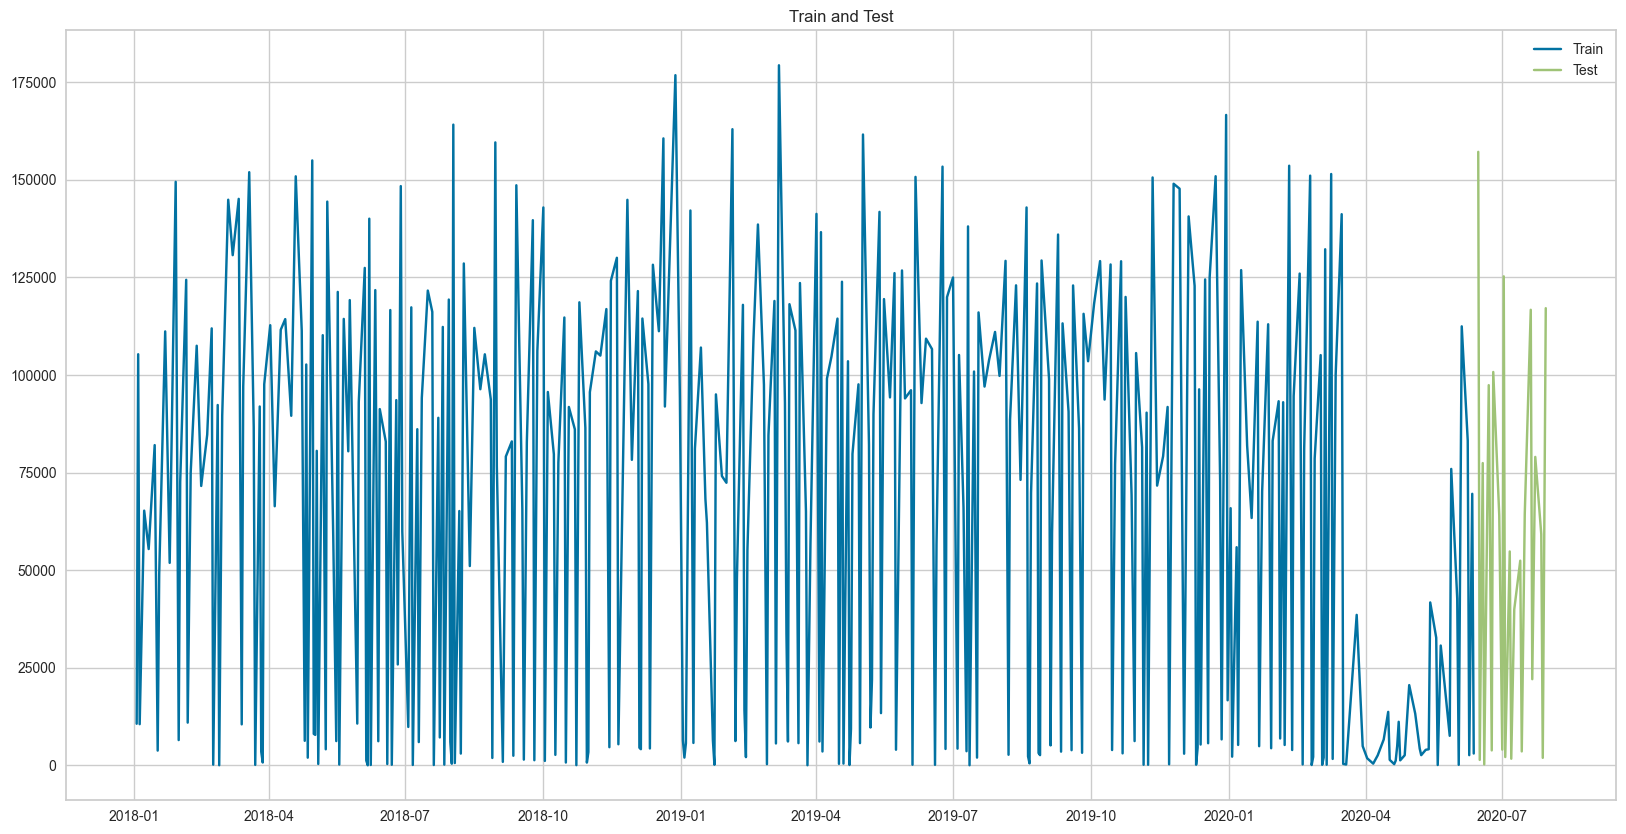

In [11]:
#plot train and test 
plt.figure(figsize=(20, 10))
plt.plot(train['sale_dollars'], label='Train')
plt.plot(test['sale_dollars'], label='Test')
plt.title('Train and Test')
plt.legend()
plt.show()


In [12]:
train.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,sale_dollars,is_weekend
date,,,,,,,,,,
2018-01-03,2,1,1,2018,3,3,1,0,10639.43,0
2018-01-04,3,1,1,2018,4,4,1,0,105307.95,0
2018-01-05,4,1,1,2018,5,5,1,0,10526.40,0
2018-01-08,0,1,1,2018,8,8,2,0,65236.68,0
2018-01-11,3,1,1,2018,11,11,2,0,55396.46,0


# Parte II

## Entrenamiento del modelo

In [13]:
## Realiza el pre-procesamiento de datos con pycaret (funcion: setup()) con la siguiente configuracion:
## Imputacion en base a la media, añade las variables categoricas generadas anteriormente, transforma las variables (incluido
## la variable objetivo)
## Configuracion adicional: combine_rare_levels = True, rare_level_threshold = 0.1,
##                  remove_multicollinearity = True, multicollinearity_threshold = 0.95,silent = True
reg = setup(data = train, target = 'sale_dollars', session_id=123, 
            normalize = True, 
            transformation = True, 
            remove_multicollinearity = True, multicollinearity_threshold = 0.95)


,Description,Value
0,Session id,123
1,Target,sale_dollars
2,Target type,Regression
3,Original data shape,"(384, 10)"
4,Transformed data shape,"(384, 7)"
5,Transformed train set shape,"(268, 7)"
6,Transformed test set shape,"(116, 7)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


In [14]:
# Entrena el mejor modelo con base al R2
best = compare_models(sort = 'R2')


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)


# Parte III

### Predicción y evaluación del modelo

##### Predicción con datos de entrenamiento

In [15]:
# Realiza una prediccion sobre los datos de train, nombralo como predictions
predictions = predict_model(best, data = train)
predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,18394.9398,632129424.1375,25142.1842,0.7842,1.7376,19.1130


,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,flag,is_weekend,sale_dollars,prediction_label
date,,,,,,,,,,,
2018-01-03,2,1,1,2018,3,3,1,0,0,10639.429688,-9658.325975
2018-01-04,3,1,1,2018,4,4,1,0,0,105307.953125,75132.768640
2018-01-05,4,1,1,2018,5,5,1,0,0,10526.400391,11126.058622
2018-01-08,0,1,1,2018,8,8,2,0,0,65236.679688,92849.306437
2018-01-11,3,1,1,2018,11,11,2,0,0,55396.460938,73866.301428


In [16]:
import plotly.express as px
# line plot
fig = px.line(predictions, x=train.index, y=["sale_dollars", "prediction_label"], template = 'plotly_dark')
fig.add_vrect(x0=min(train.index), x1=max(train.index), fillcolor="grey", opacity=0.25, line_width=0)
fig.show()

##### Evaluación del modelo

In [17]:
# Evalua el modelo sobre los datos de test
predictions = predict_model(best, data = test)


## Calcula el RMSE y MAE
print('RMSE:', np.sqrt(mean_squared_error(test['sale_dollars'], predictions['prediction_label'])))
print('MAE:', mean_absolute_error(test['sale_dollars'], predictions['prediction_label']))


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,27170.1413,1555748154.2229,39442.9734,0.3079,1.1757,2.0790


RMSE: 39442.97362331287
MAE: 27170.14108383913


In [18]:
"""
Autor: Miguel Angel Murillo Frias
Fecha: 29 de febrero de 2024
"""

'\nAutor: Miguel Angel Murillo Frias\nFecha: 29 de febrero de 2024\n'